### Connect to Drive

In [ ]:
#from google.colab import drive
#drive.mount('/gdrive')

In [ ]:
#%cd /gdrive/My Drive/ANN Exercises/Homework1

### Import libraries

In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.10.0


In [3]:
# Import dataset
#!unzip training_dataset_homework1.zip

# Dataset folders 
dataset_dir = 'training_data_final'

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
labels = ['Species1', # 1
          'Species2', # 2
          'Species3', # 3
          'Species4', # 4
          'Species5', # 5
          'Species6', # 6
          'Species7', # 7
          'Species8', # 8
]

In [7]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(validation_split=0.2, rescale=1/255.)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               subset="training",
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)
valid_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               subset="validation",
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [8]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}

Target classes
[0 0 0 ... 7 7 7]


In [9]:
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]
    target = batch[1]
    
    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

    # Visualize only the first sample
    image = image[0]
    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    fig = plt.figure(figsize=(6, 4))
    
    image = image*255
    
    plt.imshow(np.uint8(image))

    return batch

(Input) image shape: (8, 96, 96, 3)
Target shape: (8, 8)

Categorical label: [0. 1. 0. 0. 0. 0. 0. 0.]
Label: 1
Class name: Species2


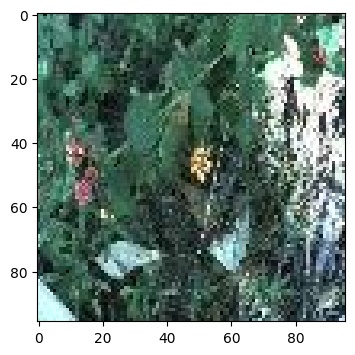

In [10]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

### Models metadata

In [11]:
input_shape = (96, 96, 3)
epochs = 200

### CNN model

In [12]:
# Download and plot the InceptionV3 model
supernet = tfk.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)
# Use the supernet as feature extractor
supernet.trainable = False

supernet.summary()
tfk.utils.plot_model(supernet)

2022-11-14 15:55:21.695774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 15:55:21.738990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-14 15:55:21.739019: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-14 15:55:21.739415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

87910968/87910968 [==============================] - 14s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 47, 47, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 47, 47, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activati

                                                                                                  
 batch_normalization_10 (BatchN  (None, 9, 9, 96)    288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 9, 9, 32)    96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 9, 9, 64)     0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 9, 9, 64)     0           ['batch_normalization_7[0][0]']  
          

                                                                                                  
 conv2d_20 (Conv2D)             (None, 9, 9, 48)     13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 9, 9, 96)     55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 9, 9, 48)    144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 9, 9, 96)    288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
          

                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 4, 4, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 4, 4, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 4, 4, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 4, 4, 128)    114688      ['activation_34[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 4, 4, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 4, 4, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 4, 4, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 4, 4, 160)    0           ['batch_normalization_45[0][0]'] 
          

                                                                                                  
 batch_normalization_55 (BatchN  (None, 4, 4, 160)   480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 4, 4, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 4, 4, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 4, 4, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_61 (Conv2D)             (None, 4, 4, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 4, 4, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 4, 4, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 4, 4, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_70 (BatchN  (None, 4, 4, 192)   576         ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 4, 4, 192)   576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 4, 4, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 4, 4, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71

 activation_79 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 1, 1, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 1, 1, 320)    0           ['batch_normalization_76[0][0]'] 
          

 batch_normalization_93 (BatchN  (None, 1, 1, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 1, 1, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 1, 1, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 1, 1, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
          

In [13]:
inputs = tfk.Input(shape=input_shape)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 Flattening (Flatten)        (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056  

In [14]:
# Train the model
history = tl_model.fit(
    x = train_gen,
    validation_data = valid_gen,
    epochs = epochs,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)],
).history

Epoch 1/200
355/355 [==============================] - 13s 32ms/step - loss: 1.7850 - accuracy: 0.3523 - val_loss: 1.5178 - val_accuracy: 0.4306
Epoch 2/200
355/355 [==============================] - 10s 29ms/step - loss: 1.4560 - accuracy: 0.4651 - val_loss: 1.4696 - val_accuracy: 0.4348
Epoch 3/200
355/355 [==============================] - 10s 29ms/step - loss: 1.3340 - accuracy: 0.5085 - val_loss: 1.4124 - val_accuracy: 0.4816
Epoch 4/200
355/355 [==============================] - 10s 29ms/step - loss: 1.2022 - accuracy: 0.5599 - val_loss: 1.4026 - val_accuracy: 0.4632
Epoch 5/200
355/355 [==============================] - 10s 29ms/step - loss: 1.1329 - accuracy: 0.5874 - val_loss: 1.4685 - val_accuracy: 0.4660
Epoch 6/200
355/355 [==============================] - 10s 29ms/step - loss: 1.0644 - accuracy: 0.6118 - val_loss: 1.4393 - val_accuracy: 0.4731
Epoch 7/200
355/355 [==============================] - 10s 29ms/step - loss: 0.9832 - accuracy: 0.6456 - val_loss: 1.4527 - val_ac

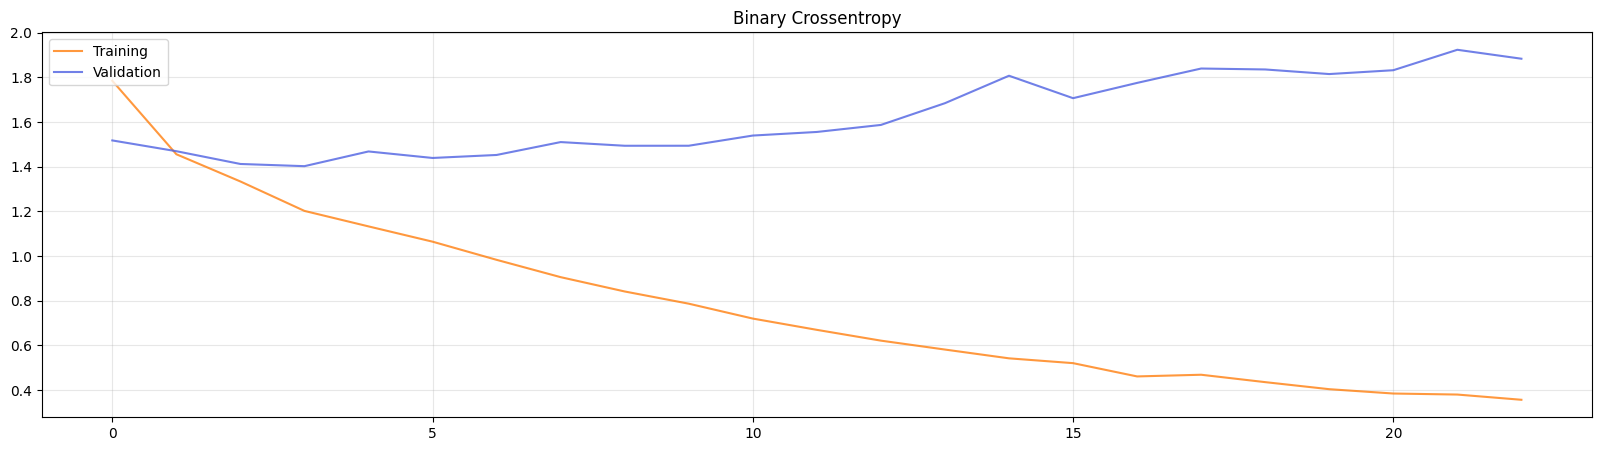

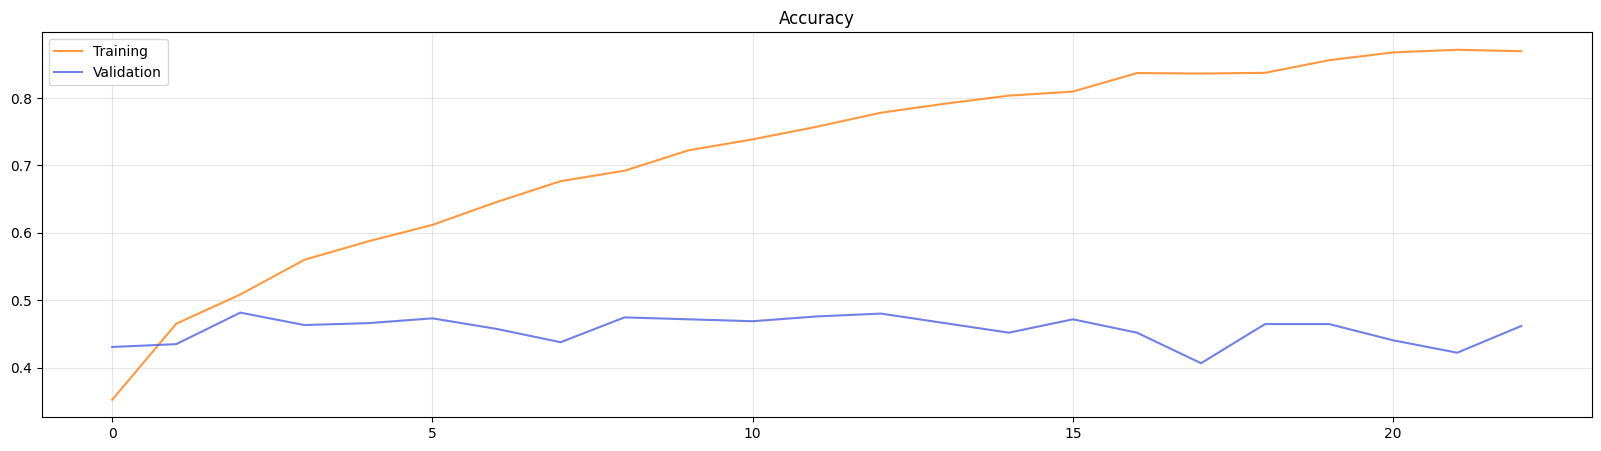

In [15]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
tl_model.save('ANN_Homework1_Model')